In [1]:
from __future__ import print_function, division
import numpy as np
import math

class l1_regularization():
    """ Regularization for Lasso Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * np.linalg.norm(w)

    def grad(self, w):
        return self.alpha * np.sign(w)

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 *  w.T.dot(w)

    def grad(self, w):
        return self.alpha * w

class l1_l2_regularization():
    """ Regularization for Elastic Net Regression """
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def __call__(self, w):
        l1_contr = self.l1_ratio * np.linalg.norm(w)
        l2_contr = (1 - self.l1_ratio) * 0.5 * w.T.dot(w) 
        return self.alpha * (l1_contr + l2_contr)

    def grad(self, w):
        l1_contr = self.l1_ratio * np.sign(w)
        l2_contr = (1 - self.l1_ratio) * w
        return self.alpha * (l1_contr + l2_contr) 

class Regression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
    variables X. 
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate

    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, ))

    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            a = self.regularization(self.w)
            mse = np.mean(0.5 * (y - y_pred)**2 + self.regularization(self.w))
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

class LinearRegression(Regression):
    """Linear model.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001, gradient_descent=True):
        self.gradient_descent = gradient_descent
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(LinearRegression, self).__init__(n_iterations=n_iterations,
                                            learning_rate=learning_rate)
    def fit(self, X, y):
        # If not gradient descent => Least squares approximation of w
        if not self.gradient_descent:
            # Insert constant ones for bias weights
            X = np.insert(X, 0, 1, axis=1)
            # Calculate weights by least squares (using Moore-Penrose pseudoinverse)
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            X_sq_reg_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_reg_inv.dot(X.T).dot(y)
        else:
            super(LinearRegression, self).fit(X, y)


class PolynomialRegression(Regression):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.001):
        self.degree = degree
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(PolynomialRegression, self).__init__(n_iterations=n_iterations,
                                                learning_rate=learning_rate)

    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolynomialRegression, self).fit(X, y)

    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolynomialRegression, self).predict(X)

class RidgeRegression(Regression):
    """Also referred to as Tikhonov regularization. Linear regression model with a regularization factor.
    Model that tries to balance the fit of the model with respect to the training data and the complexity
    of the model. A large regularization factor with decreases the variance of the model.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, reg_factor, n_iterations=1000, learning_rate=0.001):
        self.regularization = l2_regularization(alpha=reg_factor)
        super(RidgeRegression, self).__init__(n_iterations, 
                                            learning_rate)


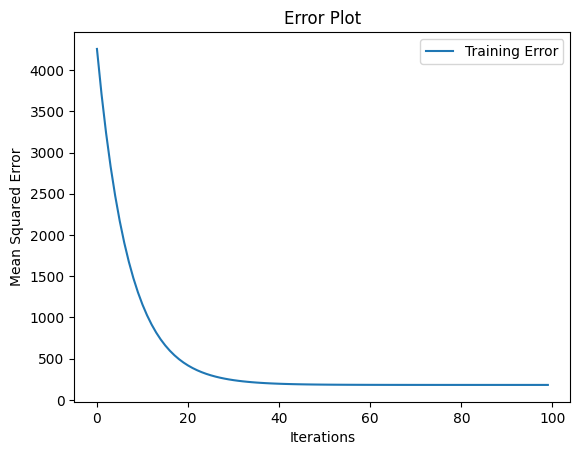

Mean squared error: 491.80941994778624


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

    
X, y = make_regression(n_samples=100, n_features=3, noise=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
n_samples, n_features = np.shape(X)
model = LinearRegression(n_iterations=100)
model.fit(X_train, y_train)

# Training error plot
n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("Mean squared error: %s" % (mse))
y_pred_line = model.predict(X)


In [5]:
import numpy as np

# Creating sample matrices
matrix_6x2 = np.random.rand(6, 2)
matrix_6x1 = np.random.rand(6, 1)

# Attempting to subtract matrix_6x1 from matrix_6x2
result = matrix_6x2 - matrix_6x1  # This will likely raise a broadcasting error
print(result)

[[-0.44330191  0.16445329]
 [ 0.20216172 -0.04835404]
 [ 0.28528823 -0.39680355]
 [ 0.00449276  0.05875275]
 [-0.73431107 -0.83760018]
 [-0.24052832  0.29002947]]
